In [1]:
from skimage import io
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.vis_utils import plot_model

In [2]:
#Load images from UTK-Face dataset

path = "/Users/ninahorstmann/Downloads/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)

images = []
ages = []
race = []
for file in files:
    image = cv2.imread(path+file,3)
    image = image.reshape((image.shape[0],image.shape[1],3))
    image = cv2.resize(image,dsize=(32,32))
    b,g,r = cv2.split(image)           # get b, g, r
    rgbimage = cv2.merge([r,g,b])      # switch it to r, g, b
    images.append(rgbimage)
    split_var = file.split('_')
    ages.append(split_var[0])
    race.append(split_var[2])

Total samples: 23708


In [3]:
#divide ages into buckets of 10, set classes
ages = [int(i) for i in ages]
classes = []
counter=0
for i in ages:
    bucket = 10 * round(int(i)/10)

    if bucket == 0:
        classes.append(0)
    elif bucket == 10:
        classes.append(1)
    elif bucket == 20:
        classes.append(2)
    elif bucket == 30:
        classes.append(3)
    elif bucket == 40:
        classes.append(4)
    elif bucket == 50:
        classes.append(5)
    elif bucket == 60:
        classes.append(6)
    elif bucket == 70:
        classes.append(7)
    elif bucket == 80:
        classes.append(8)
    elif bucket == 90:
        classes.append(9)
    elif bucket >= 100:
        classes.append(10)

In [4]:
#Isolate images labeled as 'white'
white_idx = np.where(np.array(race)=='0')[0]
white_images = [images[i] for i in white_idx]
white_ages = [classes[i] for i in white_idx]
white_ages_int = [int(i) for i in white_ages]

#Isolate images labeled as 'black'
black_idx = np.where(np.array(race)=='1')[0]
black_images = [images[i] for i in black_idx]
black_ages = [classes[i] for i in black_idx]
black_ages_int = [int(i) for i in black_ages]

#Isolate images labeled as 'asian'
asian_idx = np.where(np.array(race)=='2')[0]
asian_images = [images[i] for i in asian_idx]
asian_ages = [classes[i] for i in asian_idx]
asian_ages_int = [int(i) for i in asian_ages]

#Isolate images labeled as 'indian'
indian_idx = np.where(np.array(race)=='3')[0]
indian_images = [images[i] for i in indian_idx]
indian_ages = [classes[i] for i in indian_idx]
indian_ages_int = [int(i) for i in indian_ages]

In [5]:
#Extract indices from previous random sampling
from numpy import genfromtxt
sample_idx = genfromtxt('sample_idx.csv', delimiter=',')
white_sample_idx = sample_idx[:,0]
black_sample_idx = sample_idx[:,1]
asian_sample_idx = sample_idx[:,2]
indian_sample_idx = sample_idx[:,3]

#Withhold images that were used in audit as test set
features=[]
targets=[]
x_test=[]
y_test=[]
for i in range(len(white_images)):
    if i not in white_sample_idx:
        #Normalize samples
        image = white_images[int(i)]/255
        features.append(image)
        targets.append(white_ages[int(i)])
    else:
        image = white_images[int(i)]/255
        x_test.append(image)
        y_test.append(white_ages[int(i)])
    

sample dim: (32, 32, 3)
x_train dim: (6059, 32, 32, 3)


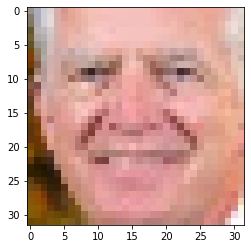

In [6]:
#convert list to arrays
features = np.squeeze(np.array(features))
x_test = np.squeeze(np.array(x_test))
targets = np.array(targets)
y_test = np.array(y_test)

#create array for class assignments
categorical_labels = to_categorical(targets, num_classes=11)

#split into training and validation folds
x_train, x_valid, y_train, y_valid = train_test_split(features, categorical_labels, test_size=0.25)

#display sample image
sample=x_train[0]
print('sample dim:',sample.shape)
print('x_train dim:', x_train.shape)
plt.imshow(sample)

In [7]:
##current best model, accuracy 0.435, somewhat overfits the training set
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3))) 
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')) 
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(11, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4128      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [8]:
model.compile(loss=['mse','categorical_crossentropy'],
             optimizer='adam',
             metrics=['accuracy'])

In [9]:
#least overfitting w/batchsize 20, epochs 20
history = model.fit(
    x_train,
    y_train,
    batch_size = 36,
    validation_data = (x_valid, y_valid),
    epochs = 20,
)

Epoch 1/20
169/169 [==============================] - 12s 68ms/step - loss: 0.2213 - accuracy: 0.1461 - val_loss: 0.1009 - val_accuracy: 0.2000
Epoch 2/20
169/169 [==============================] - 10s 60ms/step - loss: 0.0917 - accuracy: 0.1988 - val_loss: 0.0775 - val_accuracy: 0.2569
Epoch 3/20
169/169 [==============================] - 10s 62ms/step - loss: 0.0767 - accuracy: 0.2559 - val_loss: 0.0738 - val_accuracy: 0.2450
Epoch 4/20
169/169 [==============================] - 10s 58ms/step - loss: 0.0730 - accuracy: 0.2827 - val_loss: 0.0704 - val_accuracy: 0.3322
Epoch 5/20
169/169 [==============================] - 10s 61ms/step - loss: 0.0706 - accuracy: 0.3267 - val_loss: 0.0693 - val_accuracy: 0.3589
Epoch 6/20
169/169 [==============================] - 10s 62ms/step - loss: 0.0699 - accuracy: 0.3306 - val_loss: 0.0683 - val_accuracy: 0.3629
Epoch 7/20
169/169 [==============================] - 10s 58ms/step - loss: 0.0689 - accuracy: 0.3551 - val_loss: 0.0685 - val_accuracy:

In [21]:
model.save('agemodel.keras')
# summarize filter shapes
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_4 (2, 2, 3, 16)
conv2d_5 (2, 2, 16, 32)
conv2d_6 (2, 2, 32, 32)
conv2d_7 (2, 2, 32, 64)


In [11]:
y_predict = np.argmax(model.predict(x_test),axis=1)
model_accuracy = metrics.accuracy_score(y_test, y_predict)
print('model accuracy:',model_accuracy)

model accuracy: 0.4367183591795898


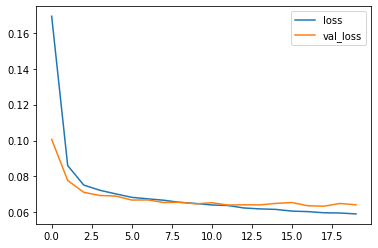

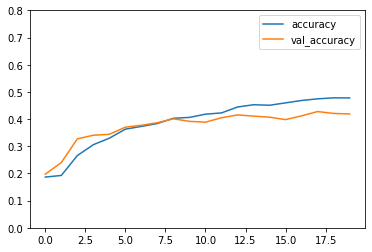

In [29]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
fig = history_frame.loc[:, ['loss', 'val_loss']].plot().get_figure()
fig.savefig('bestmodelloss.png')
fig2 = history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ylim=(0,.8)).get_figure()
fig2.savefig('bestmodelaccuracy')

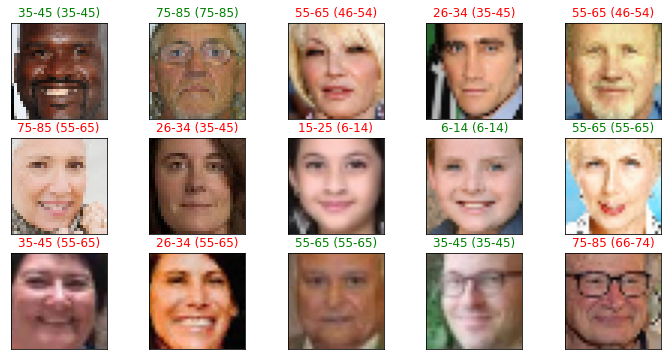

In [23]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
labels =["0-5", "6-14", "15-25", "26-34", "35-45", "46-54", "55-65", "66-74", "75-85", "86-94", "95+"
        ]
figure = plt.figure(figsize=(12, 6))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(x_test[index]), vmin=0, vmax=255)
    predict_index = y_predict[index]
    true_index = y_test[index]
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()

In [16]:
#save predicted age classes from best model
np.savetxt("mymodel_predages.csv", y_predict, delimiter =", ", 
           fmt ='% s')

In [13]:
#test sets for other races
black_x_test=[]
black_y_test=[]
for i in range(len(black_images)):
    if i in black_sample_idx:
        #Normalize samples
        image = black_images[int(i)]/255
        black_x_test.append(image)
        black_y_test.append(black_ages[int(i)])
black_x_test=np.squeeze(np.array(black_x_test))
black_y_test=np.array(black_y_test)
        
asian_x_test=[]
asian_y_test=[]
for i in range(len(asian_images)):
    if i in asian_sample_idx:
        #Normalize samples
        image = asian_images[int(i)]/255
        asian_x_test.append(image)
        asian_y_test.append(asian_ages[int(i)])
asian_x_test=np.squeeze(np.array(asian_x_test))
asian_y_test=np.array(asian_y_test)

indian_x_test=[]
indian_y_test=[]
for i in range(len(indian_images)):
    if i in indian_sample_idx:
        #Normalize samples
        image = indian_images[int(i)]/255
        indian_x_test.append(image)
        indian_y_test.append(indian_ages[int(i)])
indian_x_test=np.squeeze(np.array(indian_x_test))
indian_y_test=np.array(indian_y_test)

In [14]:
black_y_predict = np.argmax(model.predict(black_x_test),axis=1)
black_model_accuracy = metrics.accuracy_score(black_y_test, black_y_predict)
print('model accuracy for black faces:',black_model_accuracy)

asian_y_predict = np.argmax(model.predict(asian_x_test),axis=1)
asian_model_accuracy = metrics.accuracy_score(asian_y_test, asian_y_predict)
print('model accuracy for asian faces:',asian_model_accuracy)

indian_y_predict = np.argmax(model.predict(indian_x_test),axis=1)
indian_model_accuracy = metrics.accuracy_score(indian_y_test, indian_y_predict)
print('model accuracy for indian faces:',indian_model_accuracy)

print('overall accuracy:',(model_accuracy+black_model_accuracy+asian_model_accuracy+indian_model_accuracy)/4)

model accuracy for black faces: 0.3575
model accuracy for asian faces: 0.48098098098098097
model accuracy for indian faces: 0.4198396793587174
overall accuracy: 0.41988281641058744


In [17]:
#calculate other metrics for age prediction
r2_white=metrics.r2_score(y_test, y_predict)
print('WHITE FACES','r2:',r2_white)

r2_black=metrics.r2_score(black_y_test, black_y_predict)
print('BLACK FACES','r2:',r2_black)

r2_asian=metrics.r2_score(asian_y_test, asian_y_predict)
print('ASIAN FACES', 'r2:',r2_asian)

r2_indian=metrics.r2_score(indian_y_test, indian_y_predict)
print('INDIAN FACES','r2:',r2_indian)

overall_y_test = np.concatenate((y_test,black_y_test,asian_y_test,indian_y_test))
overall_y_pred = np.concatenate((y_predict,black_y_predict,asian_y_predict,indian_y_predict))
overall_r2=metrics.r2_score(overall_y_test, overall_y_pred)
print('OVERALL','r2:',overall_r2)

WHITE FACES r2: 0.6018282307899843
BLACK FACES r2: 0.043360485933150894
ASIAN FACES r2: 0.5918106753170156
INDIAN FACES r2: 0.5358308307196913
OVERALL r2: 0.5240052537479236


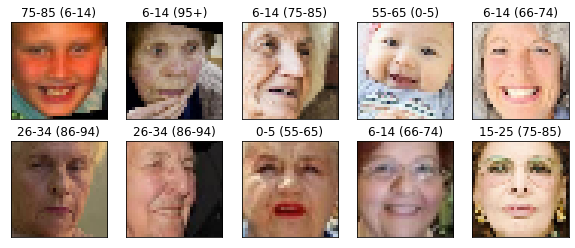

In [20]:
worst10 = np.flip(np.argpartition(np.abs(y_test-y_predict), -10)[-10:])
fig=plt.figure(figsize=(10, 4))
for i, index in enumerate(worst10):
    img = x_test[index]
    ax=fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(img)
    predict_index = y_predict[index]
    true_index = y_test[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]))

plt.show()
fig.savefig('agemodelworst10.png')

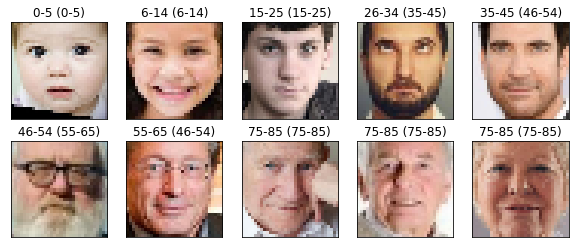

In [471]:
top10=np.argmax(model.predict(x_test),axis=0)[:10]
fig=plt.figure(figsize=(10, 4))
for i, index in enumerate(top10):
    img = x_test[index]
    ax=fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(img)
    predict_index = y_predict[index]
    true_index = y_test[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]))

plt.show()
fig.savefig('agemodeltop10.png')


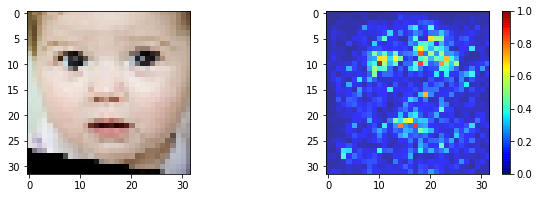

In [466]:
##display saliency map
img = x_test[top10[0]]
img = img.reshape((1, *img.shape))
test = model.predict(img)
images = tf.Variable(img, dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)
dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
fig, axes = plt.subplots(1,2,figsize=(10,3))
axes[0].imshow(x_test[top10[0]])
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)
fig.savefig('agemodelsaliencymap.png')